# MUSIC Super-resolution Microscopy

## Dependencies

In [17]:
import time
import numpy as np
import scipy.linalg
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter
from PIL import Image 
from skimage import io
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
from numba import njit, prange

# import tensorflow as tf
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

## Program Parameters

In [120]:
class params:
    k     = 2      # Source number
    M     = 8      # Sensor array size (assuming square)
    Q     = 64     # MUSIC 'Resolution'
    T     = 20     # Snapshot number
    noise = 0.00    # Noise power
    width = 1       # Sensors are placed between [-width,width]
    sep   = 1/10     # Source inter-separation distance
    sig   = 0.25/((M-1)/2)    # Gaussian kernel variance
    #sig = 1

p = params()

## Option 1: Creating Synthetic Data

$$[U]_{s,k} = u(r_s-r_k) = \exp(-\frac{1}{2\sigma}\| r_s-r_k \|^2) $$

### Plot 1D Gaussian Kernel (for viewing)

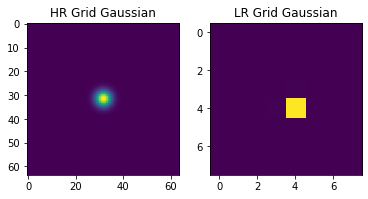

In [113]:
# Plot the 1D Kernel 
x = np.linspace(-1,1,p.Q).reshape(-1,1)
gx = np.exp(-(0.5/p.sig**2)*np.abs(x)**2)
gy = np.exp(-(0.5/p.sig**2)*np.abs(x)**2)
g  = gx @ gy.T
g[g < np.finfo(g.dtype).eps*g.max()] = 0

plt.figure()
plt.subplot(1,2,1)
plt.title('HR Grid Gaussian')
plt.imshow(g)
plt.subplot(1,2,2)
plt.imshow(g[::p.Q//p.M,::p.Q//p.M])
plt.title('LR Grid Gaussian')
plt.axis("image")
plt.show()

### Create Synthetic Measurement Data

In [105]:
#https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx,array[idx]

#https://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python
# no need to import extra module
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

#### 1a: Create Diagonals

In [114]:
# Generate diagonal 2D source positions
r_kx = np.linspace(-p.sep*p.width,p.sep*p.width,p.k).reshape(-1,1)
r_ky = np.linspace(-p.sep*p.width,p.sep*p.width,p.k).reshape(-1,1)
r_k  = np.hstack((r_kx,r_ky))

# Create High-resolution image representation of source positions
hr_sx = np.linspace(-p.width,p.width,p.Q).reshape(-1,1)
hr_sy = np.linspace(-p.width,p.width,p.Q).reshape(-1,1)

truth_img = np.zeros((p.Q,p.Q))
for x,y in r_k:
    indx,_ = find_nearest(hr_sx,x)
    indy,_ = find_nearest(hr_sy,y)
    truth_img[indx,indy] = 1.0

#### 1b: or Get from Image

64
8
The image contains 2 sources, so M of at least 1.0 is desired.


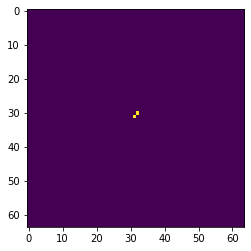

In [128]:
# Generate 2D source positions from image
#img = plt.imread("multidiag3.tif")
img = np.array(Image.open('truths/truth_0.png'))
img = rgb2gray(img)

# Get HR grid size from image instead
p.Q = img.shape[0]

####
p.M = p.Q//8
p.sig   = 0.25/((p.M-1)/2)  

print(p.Q)
print(p.M)

# Create that HR grid w/ proper distances
hr_sx = np.linspace(-p.width,p.width,p.Q).reshape(-1,1)
hr_sy = np.linspace(-p.width,p.width,p.Q).reshape(-1,1)

# Get non-zero indicies from truth
r_ind = np.asarray(np.nonzero(img.T)).T

# Get number of sources
p.k = r_ind.shape[0]
print('The image contains {} sources, so M of at least {} is desired.'.format(p.k,np.floor(np.sqrt(p.k))))

# Convert it to distances, and finalize r_k
r_kx = hr_sx[r_ind[:,0]]
r_ky = hr_sy[r_ind[:,1]]
r_k  = np.hstack((r_kx,r_ky))

# Assign truth to proper float variable
truth_img = np.zeros((p.Q,p.Q),dtype=float)
for n,m in r_ind:
    truth_img[m,n] = 1.0
plt.imshow(truth_img)
plt.show()

#### 1c: Random Localizations

(2, 2)


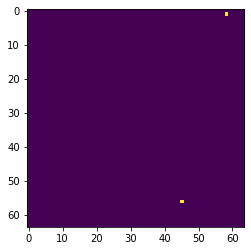

In [141]:
# Create High-resolution image representation of source positions
hr_sx = np.linspace(-p.width,p.width,p.Q).reshape(-1,1)
hr_sy = np.linspace(-p.width,p.width,p.Q).reshape(-1,1)

r_k = np.random.choice(hr_sx[:,0], (p.k,2)) # assming square image
print(r_k.shape)

truth_img = np.zeros((p.Q,p.Q))
for x,y in r_k:
    indx,_ = find_nearest(hr_sx,x)
    indy,_ = find_nearest(hr_sy,y)
    truth_img[indx,indy] = 1.0

truth_img = truth_img.T
plt.imshow(truth_img)
plt.show()

#### 2a: Create Flourescent Sequence

In [142]:
%%time
# Create 2D (low-resolution) measurement array
r_sx = np.linspace(-p.width,p.width,p.M).reshape(-1,1)
r_sy = np.linspace(-p.width,p.width,p.M).reshape(-1,1)
r_s  = np.hstack((r_sx,r_sy))

# From source positions, and the sensors, create the sensing matrix
U = np.zeros((p.M**2,p.k))
for k in range(p.k):
    r  = r_k[k]
    arg = r_s - r
    uflat = np.exp(-(0.5/p.sig**2)*np.abs(arg)**2)
    ux = uflat[:,0].reshape(-1,1)
    uy = uflat[:,1].reshape(-1,1)
    Uk = ux @ uy.T.conj()
    U[:,k] = Uk.flatten('F')

# Construct random flucations over frames for the sources
x = np.random.uniform(0,1,(p.k,p.T));
# Construct additive noise (clip if less than 0)
n = p.noise*np.random.randn(p.M**2,p.T)
n[np.where(n < 0)] = 0

# Construct final measurements
f = U @ x + n

# Noiseless Measurements
f_nl = U @ x;

CPU times: user 1.74 ms, sys: 84 µs, total: 1.83 ms
Wall time: 1.06 ms


#### 2b: Create one weak and one strong source

In [8]:
p.k = 2
bright=[1, 4]

# Generate diagonal 2D source positions
r_kx = np.linspace(-p.sep*p.width,p.sep*p.width,2).reshape(-1,1)
r_ky = np.linspace(-p.sep*p.width,p.sep*p.width,2).reshape(-1,1)
r_k  = np.hstack((r_kx,r_ky))

# Create High-resolution image representation of source positions
hr_sx = np.linspace(-p.width,p.width,p.Q).reshape(-1,1)
hr_sy = np.linspace(-p.width,p.width,p.Q).reshape(-1,1)

truth_img = np.zeros((p.Q,p.Q))
for i,xy in enumerate(r_k):
    x,y = xy
    indx,_ = find_nearest(hr_sx,x)
    indy,_ = find_nearest(hr_sy,y)
    truth_img[indx,indy] = bright[i]
    
# Create 2D (low-resolution) measurement array
r_sx = np.linspace(-p.width,p.width,p.M).reshape(-1,1)
r_sy = np.linspace(-p.width,p.width,p.M).reshape(-1,1)
r_s  = np.hstack((r_sx,r_sy))

# From source positions, and the sensors, create the sensing matrix
U = np.zeros((p.M**2,p.k))
for k in range(p.k):
    r  = r_k[k]
    arg = r_s - r
    uflat = np.exp(-(0.5/p.sig**2)*np.abs(arg)**2)
    ux = uflat[:,0].reshape(-1,1)
    uy = uflat[:,1].reshape(-1,1)
    Uk = ux @ uy.T.conj()
    U[:,k] = Uk.flatten('F')

# Construct random flucations over frames for the sources
x  = np.zeros((p.k,p.T))
for k in range(p.k): 
    x[k,:] = np.random.uniform(0,bright[k],(1,p.T))

# Construct additive noise (clip if less than 0)
n = p.noise*np.random.randn(p.M**2,p.T)
n[np.where(n < 0)] = 0

# Construct final measurements
f = U @ x + n

# Noiseless Measurements
f_nl = U @ x;

#### 3: Save as Sequence File

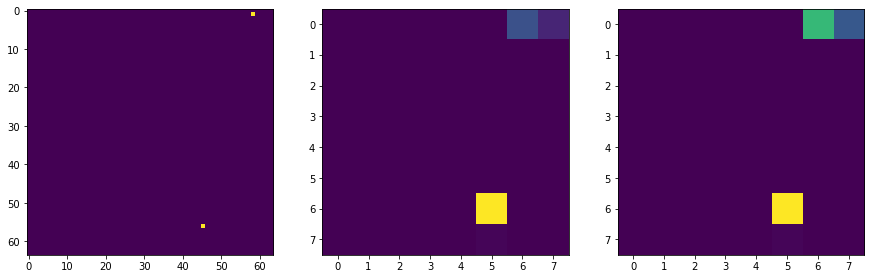

2 Sources
Data Type: float64


In [143]:
plt.figure(figsize=(15,7))
plt.subplot(1,3,1)
plt.imshow(truth_img,vmin=0.,vmax=1.)
plt.subplot(1,3,2)
plt.imshow(np.mean(f,axis=1).reshape(-1,p.M))
plt.subplot(1,3,3)
plt.imshow(f[:,np.random.randint(p.T)].reshape(-1,p.M))

plt.show()
print("{} Sources".format(p.k))

print("Data Type: {}".format(f.dtype))

In [12]:
image_data = np.moveaxis(f.reshape(p.M,p.M,p.T), -1, 0)

image_list = []
for frame in image_data:
    frame = frame/np.max(frame)
    frame = frame.astype("float32") # save as 32-bit floating point image
    image_list.append(Image.fromarray(frame))
    
image_list[0].save("training.tif", save_all=True, append_images=image_list[1:])

Image.fromarray(truth_img).save("truth.tif")

np.save("params.npy",p)

# Option 2: Load Sequence File

In [50]:
dataset = Image.open('testStack_SimulatedMicrotubules.tif') # keep image functionally for dataset
truth_img = np.array(Image.open('truth.tif'))

p.T = dataset.n_frames
p.M = np.shape(dataset)[0]   # Assume square
#p.Q = np.shape(truth_img)[0]
p.Q = p.M*8
#p.k = np.array(np.nonzero(truth_img)).T.shape[0]
p.k = 1000

# NOTE: ######################################################################### 
# The sigma used must be provided
p.sig = 1/((p.M-1)/2)
#p.sig = p.sig
#################################################################################


print("{} Sources".format(p.k))
print("{} Square Grid Size".format(p.M))
print("{} Snapshots".format(p.T))

# Create 2D (low-resolution) measurement array
r_sx = np.linspace(-p.width,p.width,p.M).reshape(-1,1)
r_sy = np.linspace(-p.width,p.width,p.M).reshape(-1,1)
r_s  = np.hstack((r_sx,r_sy))

f = np.zeros((p.M**2,dataset.n_frames))
for t in range(p.T):
    dataset.seek(t)
    frame = np.array(dataset)
    frame = frame.astype(np.double)
    frame = frame/np.max(frame)
    #f[...,t] = frame.reshape(-1,order='F')
    f[...,t] = frame.reshape(-1)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(truth_img)
plt.title('Truth')
plt.subplot(1,2,2)
plt.imshow(np.mean(f,axis=1).reshape(p.M,p.M))
plt.title('Diffraction Limited')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'testStack_SimulatedMicrotubules.tif'

## Perform MUSIC to recover sources

In [144]:
def MUSIC1D(data, sensor_pos, source_num, width, sig, HR_grid_size):
    # Perform SVD on the data
    U,_,_ = np.linalg.svd(data,full_matrices=True)
        
    # Select columns of U which correspond to noise-subspace
    U2 = U[:,source_num:]
    # Create Grid for MUSIC
    HR_sensor_pos = np.linspace(-width,width,HR_grid_size)
    # Create HR sensing matrix
    A = np.exp(-(0.5/p.sig**2)*np.abs(sensor_pos[:,np.newaxis] - HR_sensor_pos)**2)
    # Calculate error between sensor image and projection, and invert for MUSIC result
    #err = np.linalg.norm( A - U2 @ U2.conj().T @ A, axis=0 )**2
    music = np.zeros(HR_grid_size)
    for i in range(HR_grid_size):
        err = A[:,i].T.conj() @ (U2@U2.T.conj()) @ A[:,i]
        music[i] = 1/err
    
    return HR_sensor_pos,music

@njit
def MUSIC2D(data, source_num, width, sig, HR_grid_size):
    # Create low-resolution sensors
    sensor_x = np.linspace(-width,width, int(np.sqrt(data.shape[0]))).reshape(-1,1)
    sensor_y = np.linspace(-width,width, int(np.sqrt(data.shape[0]))).reshape(-1,1)
    sensor_pos = np.hstack((sensor_x, sensor_y))
    
    # Perform SVD on the data
    U,s,_ = np.linalg.svd(data, full_matrices=True)
    
    # Select columns of U which correspond to noise-subspace
    U2 = U[:,source_num:]
    
    # Create Grid for MUSIC
    HR_sensor_pos_x = np.linspace(-width,width,HR_grid_size).reshape(-1,1)
    HR_sensor_pos_y = np.linspace(-width,width,HR_grid_size).reshape(-1,1)
    HR_sensor_pos   = np.hstack((HR_sensor_pos_x, HR_sensor_pos_y))

    # Create HR sensing matrix
    print('Creating High Resolution Sensing Matrix...')
    A = np.zeros((sensor_pos.shape[0]**2,HR_grid_size**2))

    q = 0
    for jj in range(HR_grid_size):
        for ii in range(HR_grid_size):
            r  = np.array([HR_sensor_pos[ii,0], HR_sensor_pos[jj,1]])
            arg = sensor_pos - r
            aflat = np.exp(-(0.5/sig**2)*np.abs(arg)**2)
            ax = aflat[:,0]
            ay = aflat[:,1]
            #Aq = ax @ ay.T.conj()
            Aq = np.outer(ax,ay.conj())
            A[:,q] = Aq.T.flatten()
            q = q + 1

    # Calculate error between sensor image and projection, and invert for MUSIC result
    
    print('Calculating 2D MUSIC Result...')
    result = U2.conj().T @ A
    # Method 1
    music  = np.zeros(result.shape[1])
    for jj in range(result.shape[1]):
        err = np.linalg.norm(result[:,jj])**2
        music[jj] = 1/err
    
    # Method 2
#     err = np.linalg.norm(result, axis=0)**2
#     music = 1/err
    
    return s,HR_sensor_pos,music



In [145]:
#singval,music_axis, music = MUSIC2D(f,r_s,150,p.width,p.sig,p.Q)
#singval,music_axis, music = MUSIC2D(f,r_s,np.minimum(p.k,p.T),p.width,0.7/(p.M//2),p.Q)
singval,music_axis, music = MUSIC2D(f,np.minimum(p.k,p.T),p.width,p.sig,p.Q)

Creating High Resolution Sensing Matrix...
Calculating 2D MUSIC Result...


## Display Results

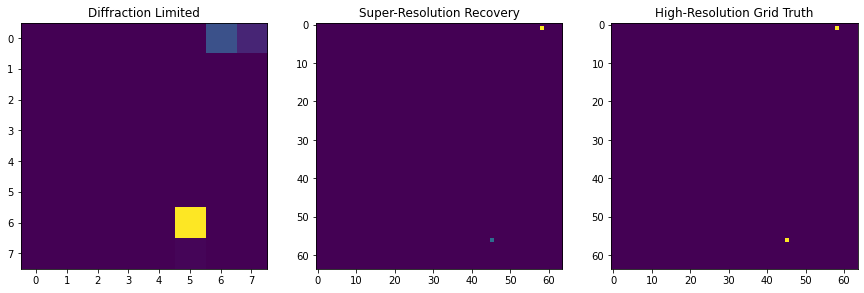

Normalized MSE: 0.00010248863831849773


In [146]:
plt.figure(figsize=(15,5))
#plt.figure()

plt.set_cmap('viridis')

p1 = plt.subplot(1,3,3)
plt.imshow(truth_img)
plt.title("High-Resolution Grid Truth")

p2 = plt.subplot(1,3,1)
dif_img = np.mean(f,axis=1).reshape(-1,p.M)
plt.imshow(dif_img)
plt.title("Diffraction Limited")

p2 = plt.subplot(1,3,2)
music_img = music.reshape(p.Q,p.Q)/np.max(music)
plt.imshow(music_img)
plt.title("2D MUSIC Super-Resolution")
plt.title("Super-Resolution Recovery")

#plt.savefig("results/dna_5000_result.png",facecolor='w')
plt.show()


print("Normalized MSE: {}".format(np.mean((truth_img - music_img)**2)))

#plt.imsave("truth.png", truth_img, cmap='magma')
#plt.imsave("super.png", music_img, cmap='magma')


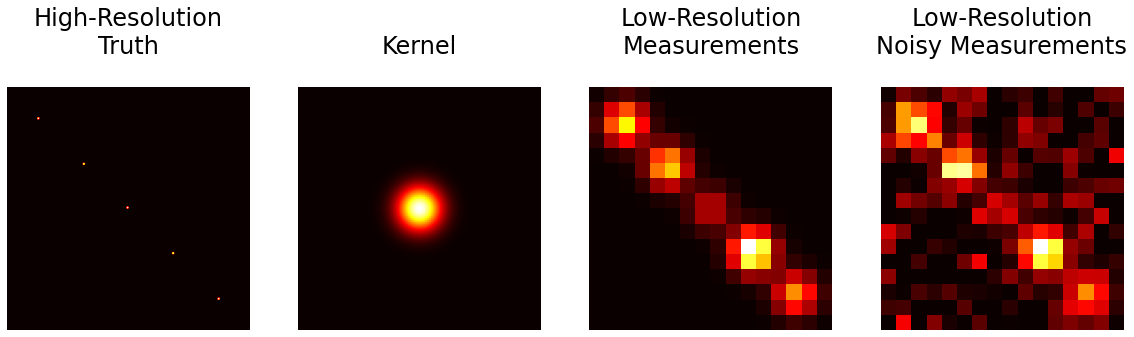

In [316]:
plt.figure(figsize=(20,10))


plt.set_cmap('hot')

p1 = plt.subplot(1,4,1)
plt.imshow(truth_img)
plt.axis('off')
plt.title('High-Resolution\nTruth\n',fontsize=24)

p2 = plt.subplot(1,4,2)
plt.imshow(g)
plt.axis('off')
plt.title('Kernel\n',fontsize=24);

p3 = plt.subplot(1,4,3)
plt.imshow(f_nl[:,1].reshape(-1,p.M))
plt.axis('off')
plt.title('Low-Resolution\nMeasurements\n',fontsize=24);

p4 = plt.subplot(1,4,4)
plt.imshow(f[:,1].reshape(-1,p.M))
plt.axis('off')
plt.title('Low-Resolution\nNoisy Measurements\n',fontsize=24)

# p5 = plt.subplot(1,5,5)
# plt.imshow(music_img)
# plt.axis('off')
# plt.title('Super-Resolution\nImage\n',fontsize=24)

plt.savefig("fig.png");

(1024, 5000)


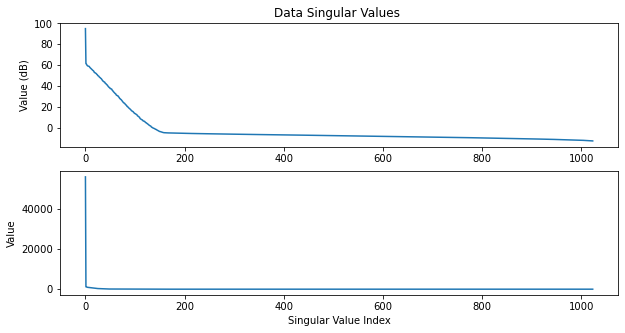

In [307]:
plt.figure(figsize=(10,5))

singval = scipy.linalg.svdvals(f)
print(f.shape)

plt.subplot(2,1,1)
plt.plot(20*np.log10(singval))
plt.title("Data Singular Values ")
plt.ylabel("Value (dB)")

plt.subplot(2,1,2)
plt.plot(singval)
plt.xlabel("Singular Value Index")
plt.ylabel("Value")


plt.savefig("results/dna_singvals_5000.png",facecolor='w')

## Save Gif

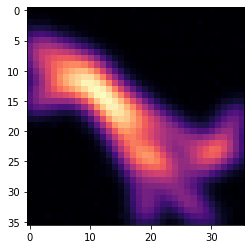

In [136]:
sequence = []
for t in range(p.T):
    img  = f[:,t].reshape(-1,p.M);
    norm = plt.Normalize(vmin=img.min(), vmax=img.max())
    cmap = plt.cm.magma
    img  = np.uint8(255*cmap(norm(img)))
    img  = Image.fromarray(img)
    sequence.append(img)
plt.imshow(img)
sequence[0].save('sequence.gif', save_all=True, append_images=sequence[1:])